# Grover's search for D-optimal sequences

In [1]:
import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
%config InlineBackend.figure_formats = {'png', 'retina'}
matplotlib.rcParams['figure.figsize'] = (8.0, 5.0)

from quantum import *
from math import log, ceil, floor
from lib import paf, psd


# search for D-optimal sequences length=3
seq_len = 3

/usr/local/lib/python3.5/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
def equal(a, b):
    EPSILON = 0.00001
    return abs(a - b) < EPSILON


def is_d_optimal(A, B):
    # check PAF invariant
    M = int((seq_len-1)/2)
    for s in range(1, M+1):
        if paf(A, s) + paf(B, s) != 2: return False
    
    # check PSD invariant
    cond = 2*seq_len - 2
    for k in range(1, seq_len):
        # non negativity of PSD. we can discard before computing PSD both times
        psd_a = psd(A, k)
        if psd_a > cond: return False
        psd_b = psd(B, k)
        if psd_b > cond: return False
        if not equal(psd_a + psd_b, cond): return False
    
    return True


def bits_to_seq(bitstring):
    return [-1 if i == '0' else 1 for i in bitstring]


def is_bitstring_doptimal(bitstring):
    """
    Returns whether the given input is a binary encoding of two sequences that
    are mutually D-optimal.
    
    :param: bitstring (int) length = seq_len
    :returns: (bool)
    """
    # get first half of bitstring
    first_half = bitstring >> seq_len
    # get second half
    bitmask = (2 ** seq_len) - 1 # 111...1 (length = N)
    second_half = bitstring & bitmask
    
    bits_A = "{:0{width}b}".format(first_half, width=seq_len)
    bits_B = "{:0{width}b}".format(second_half, width=seq_len)
    
    seq_A = bits_to_seq(bits_A)
    seq_B = bits_to_seq(bits_B)

    return is_d_optimal(seq_A, seq_B)

In [3]:
# 2, 5, 16, 23, 40, 47, 58, 61 are D-optimal bitstrings
dopt_bitstrings = [bits for bits in range(2**(2*seq_len)) if is_bitstring_doptimal(bits)]
print(', '.join(str(b) for b in dopt_bitstrings))

2, 5, 16, 23, 40, 47, 58, 61


sequence length: 3
qubits: 6
search space: 64
recall that the d-optimal bitstrings are
2, 5, 16, 23, 40, 47, 58, 61

peak probability: 12.497%
significant qubit probabilities
  2 (0000010)   12.497%
  5 (0000101)   12.497%
 16 (0010000)   12.497%
 23 (0010111)   12.497%
 40 (0101000)   12.497%
 47 (0101111)   12.497%
 58 (0111010)   12.497%
 61 (0111101)   12.497%


<IPython.core.display.Javascript object>


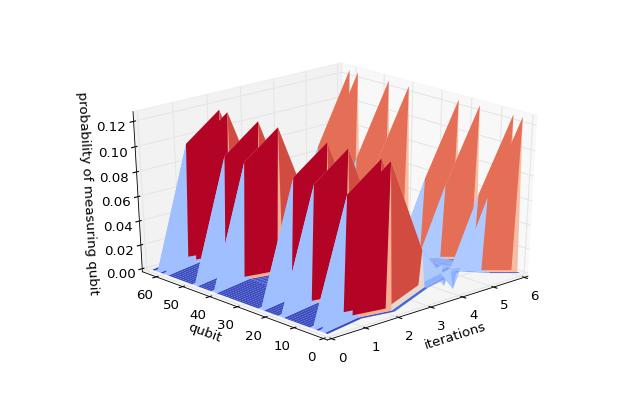

In [4]:
def grovers_plot(func, qubits, N=None, iterations=None):    
    if N is None:
        N = 2 ** qubits

    # input: |00...0> (length n)
    # output: |0>
    state = Q(kron(*(zero for _ in range(qubits)), zero))

    # Apply HX to the output register.
    state = state.apply_gate(X, 0)
    state = state.apply_gate(H, 0)

    # Apply H^n to the input register.
    # input register: qubits 1 to n
    input_H = kron(*(H for _ in range(qubits)), I)
    state = state.apply_unitary(input_H)

    # First, we'll compute the diffusion operator.
    # this definition of D (the diffusion matrix aka. inversion about the mean)
    # is given in Grover's original paper
    P = 1/N * np.ones((N, N))
    D = kron(-np.eye(N) + 2*P, I)
    
    if iterations is None:
        iterations = floor((np.pi/4) * sqrt(N).real)
        
    zgrid = np.zeros((iterations+1, 2**qubits))

    np.set_printoptions(precision=2)
    
    # Now we perform the Grover iteration.
    for iteration in range(1, iterations+1):
        state = state.apply_func(func)
        state = state.apply_unitary(D)
        amplitudes = to_row(state.state)
        probs = [(abs(a) ** 2).real for a in amplitudes]
        
        for qubit, prob in enumerate(probs):
            bitstring = qubit >> 1
            zgrid[iteration][bitstring] += prob
            
    print("peak probability: {:.3f}%".format(100*zgrid.max()))
    
    print("significant qubit probabilities")
    amplitudes = to_row(state.state)
    probs = [(abs(a) ** 2).real for a in amplitudes]
    bitstrings = {}
    for qubit, prob in enumerate(probs):
        bitstring = qubit >> 1 # chop off output register
        bitstrings[bitstring] = bitstrings.get(bitstring, 0) + prob
    for bitstring, prob in bitstrings.items():
        if prob < 0.0001: continue
        print("{0:3} ({0:0{width}b})  {1:7.3f}%".format(bitstring, 100*prob, width=2*seq_len+1))
    

    ax = plt.axes(projection='3d')
    ax.set_xlabel('iterations')
    ax.set_ylabel('qubit')
    ax.set_zlabel('probability of measuring qubit')
    ax.set_xlim(0, iterations)
    ax.set_ylim(0, 2**qubits)
    ax.set_zlim(0.0, zgrid.max())
    
    xscale = list(range(iterations+1))
    yscale = list(range(2**qubits))
    xmesh, ymesh = np.meshgrid(xscale, yscale)
    ax.plot_surface(xmesh.T, ymesh.T, zgrid, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0)

# we need 2 * N qubits to search through sequence pairs
qubits = seq_len * 2
space_size = 2 ** qubits

print('sequence length:', seq_len)
print('qubits:', qubits)
print('search space:', space_size)

print("recall that the d-optimal bitstrings are")
print(', '.join(str(b) for b in dopt_bitstrings))
print()
    
def func(x):
    return 1 if is_bitstring_doptimal(x) else 0
    
grovers_plot(func, qubits=qubits, iterations = 6)